In [5]:
import pandas as pd
import numpy as np
import scipy.stats as scipy
import matplotlib.pyplot as plt
import requests #download from football data
import io 
from __future__ import division
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

# Functions

In [6]:
def transformResult(row):
    if(row.FTR == 'H'):
        return 1
    elif(row.FTR == 'A'):
        return -1
    else:
        return 0
    
def transformResultBack(row,col_name):
    if(row[col_name] == 1):
        return 'H'
    elif(row[col_name] == -1):
        return 'A'
    else:
        return 'D'

In [7]:
#URLs for Datasets
url_laliga = 'https://www.football-data.co.uk/mmz4281/2122/SP1.csv'
url_premier = 'https://www.football-data.co.uk/mmz4281/2122/E0.csv'
url_serie = 'https://www.football-data.co.uk/mmz4281/2122/I1.csv'
url_bundes = 'https://www.football-data.co.uk/mmz4281/2122/D1.csv'
url_ligone = 'https://www.football-data.co.uk/mmz4281/2122/F1.csv'

#Lists of the league's teams
laligaTeams = ['Alaves','Ath Bilbao','Ath Madrid','Barcelona','Betis','Cadiz','Celta','Elche','Espanol','Getafe','Granada','Levante','Mallorca','Osasuna','Real Madrid','Sevilla','Sociedad','Valencia','Vallecano','Villarreal']
premierTeams = ['Arsenal','Aston Villa','Brentford','Brighton','Burnley','Chelsea','Crystal Palace','Everton','Leeds','Leicester','Liverpool','Man City','Man United','Newcastle','Norwich','Southampton','Tottenham','Watford','West Ham','Wolves']
serieATeams = []
bundesligaTeams = []
LigueOneTeams = []

In [8]:
print("(1)Premier League (2)La Liga (3)Bundesliga (4)League One (5)Serie A")
n_league = int(input("Please Enter the Number of the League Desired: "))

(1)Premier League (2)La Liga (3)Bundesliga (4)League One (5)Serie A
Please Enter the Number of the League Desired: 1


In [9]:
if n_league == 1:
    url = url_premier
elif n_league == 2:
    url = url_laliga
elif n_league == 3:
    url = url_bundes
elif n_league == 4:
    url = url_ligone   
elif n_league == 5:
    url = url_serie
else:
    url = url_laliga

In [10]:
content = requests.get(url).content
df = pd.read_csv(io.StringIO(content.decode('utf-8')))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Cleaning & Subsetting Data

In [11]:
res_16 = df.iloc[:,:23]
if n_league == 1:
    res_16 = res_16.drop(['Div','Date','Time','Referee'],axis=1)
    table_features = df.iloc[:,:7]
    table_features = table_features.drop(['FTHG','FTAG','Div','Date','Time'],axis=1)
    bet_16 = df.iloc[:,23:]
    feature_table = df.iloc[:,:23]
    feature_table = feature_table.drop(['Referee'],axis=1) 
else:
    res_16 = res_16.drop(['Div','Date','Time'],axis=1)
    table_features = df.iloc[:,:7]
    table_features = table_features.drop(['FTHG','FTAG','Div','Date','Time'],axis=1)
    bet_16 = df.iloc[:,23:]
    feature_table = df.iloc[:,:23]

feature_table

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,H,8,22,3,4,12,8,2,5,0,0,0
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,H,16,10,8,3,11,9,5,4,1,2,0
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,H,14,14,3,8,10,7,7,6,2,1,0
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,H,13,4,6,1,15,11,5,2,0,0,0
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,A,14,6,6,3,13,15,6,8,2,0,0
5,E0,14/08/2021,15:00,Leicester,Wolves,1,0,H,1,0,H,9,17,5,3,6,10,5,4,1,2,0
6,E0,14/08/2021,15:00,Watford,Aston Villa,3,2,H,2,0,H,13,11,7,2,18,13,2,4,3,1,0
7,E0,14/08/2021,17:30,Norwich,Liverpool,0,3,A,0,1,A,14,19,3,8,4,14,3,11,1,1,0
8,E0,15/08/2021,14:00,Newcastle,West Ham,2,4,A,2,1,H,17,8,3,9,4,3,7,6,1,0,0
9,E0,15/08/2021,16:30,Tottenham,Man City,1,0,H,0,0,D,13,18,3,4,11,8,3,11,2,1,0


In [12]:
#Team, Home Goals Score, Away Goals Score, Attack Strength, Home Goals Conceded, Away Goals Conceded, Defensive Strength
table_16 = pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS',))

avg_home_scored_16 = res_16.FTHG.sum()*1.0 / res_16.shape[0]
avg_away_scored_16 = res_16.FTAG.sum()*1.0 / res_16.shape[0]
avg_home_conceded_16 = avg_away_scored_16
avg_away_conceded_16 = avg_home_scored_16
print("Average number of goals at home",avg_home_scored_16)
print("Average number of goals away", avg_away_scored_16)
print("Average number of goals conceded at home",avg_home_conceded_16)
print("Average number of goals conceded away",avg_away_conceded_16)

Average number of goals at home 1.5549738219895288
Average number of goals away 1.293193717277487
Average number of goals conceded at home 1.293193717277487
Average number of goals conceded away 1.5549738219895288


In [13]:
res_home = res_16.groupby('HomeTeam')
res_away = res_16.groupby('AwayTeam')

In [14]:
if n_league == 1:
    table_16.Team = premierTeams
elif n_league == 2: 
    table_16.Team = laligaTeams
table_16.HGS = res_home.FTHG.sum().values
table_16.HGC = res_home.FTAG.sum().values
table_16.AGS = res_away.FTAG.sum().values
table_16.AGC = res_away.FTHG.sum().values
table_16.Team

0            Arsenal
1        Aston Villa
2          Brentford
3           Brighton
4            Burnley
5            Chelsea
6     Crystal Palace
7            Everton
8              Leeds
9          Leicester
10         Liverpool
11          Man City
12        Man United
13         Newcastle
14           Norwich
15       Southampton
16         Tottenham
17           Watford
18          West Ham
19            Wolves
Name: Team, dtype: object

In [15]:
num_games = res_16.shape[0]/20
table_16.HAS = (table_16.HGS / num_games) / avg_home_scored_16
table_16.AAS = (table_16.AGS / num_games) / avg_away_scored_16
table_16.HDS = (table_16.HGC / num_games) / avg_home_conceded_16
table_16.ADS = (table_16.AGC / num_games) / avg_away_conceded_16

In [16]:
table_16

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS
0,Arsenal,18,15,1.212121,1.214575,8,17,0.647773,1.144781
1,Aston Villa,15,10,1.010101,0.809717,14,16,1.133603,1.077441
2,Brentford,12,11,0.808081,0.890688,12,14,0.971660,0.942761
3,Brighton,8,12,0.538721,0.971660,9,11,0.728745,0.740741
4,Burnley,8,8,0.538721,0.647773,8,19,0.647773,1.279461
5,Chelsea,25,20,1.683502,1.619433,10,6,0.809717,0.404040
6,Crystal Palace,20,9,1.346801,0.728745,12,18,0.971660,1.212121
7,Everton,15,8,1.010101,0.647773,16,16,1.295547,1.077441
8,Leeds,13,8,0.875421,0.647773,16,21,1.295547,1.414141
9,Leicester,16,15,1.077441,1.214575,12,21,0.971660,1.414141


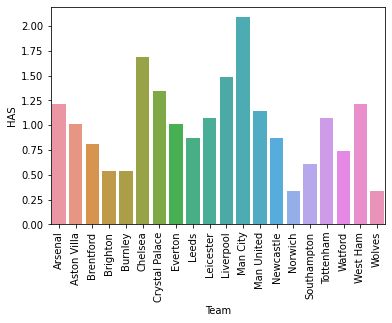

In [17]:
has_plot = sns.barplot(table_16.Team,table_16.HAS)
for item in has_plot.get_xticklabels():
    item.set_rotation(90)

# Training Data

In [18]:
feature_table = feature_table[['HomeTeam','AwayTeam','FTR','HST','AST']]

f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in feature_table.iterrows():
    f_HAS.append(table_16[table_16['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table_16[table_16['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table_16[table_16['Team'] == row['AwayTeam']]['AAS'].values[0])
    f_ADS.append(table_16[table_16['Team'] == row['AwayTeam']]['ADS'].values[0])
    
feature_table['HAS'] = f_HAS
feature_table['HDS'] = f_HDS
feature_table['AAS'] = f_AAS
feature_table['ADS'] = f_ADS

feature_table["Result"] = feature_table.apply(lambda row: transformResult(row),axis=1)

X_train = feature_table[['HST','AST','HAS','HDS','AAS','ADS']]
y_train = feature_table['Result']

clf1 = RandomForestClassifier()
clf2 = MultinomialNB()
clf3 = XGBClassifier()
clf4 = LinearSVC()

In [19]:
print('Random Forest Classifier') 
y_pred = clf1.fit(X_train,y_train).predict(X_train)
accuracy_score(y_pred,y_train)
scores = cross_val_score(clf1, X_train, y_train, cv=30)
print(scores)
print(scores.mean())

Random Forest Classifier
[0.42857143 0.57142857 0.28571429 0.42857143 0.85714286 0.57142857
 0.28571429 0.71428571 0.71428571 0.57142857 0.42857143 0.5
 0.5        0.16666667 0.5        0.66666667 0.66666667 0.66666667
 0.33333333 0.66666667 0.5        0.66666667 0.66666667 0.5
 0.83333333 0.5        0.66666667 0.66666667 0.5        0.83333333]
0.5619047619047618


In [20]:
print('MultinoialNB')
y_pred = clf2.fit(X_train,y_train).predict(X_train)
accuracy_score(y_pred,y_train)
scores = cross_val_score(clf2, X_train, y_train, cv=30)
print(scores)
print(scores.mean())

MultinoialNB
[0.57142857 0.57142857 0.57142857 0.42857143 0.71428571 0.57142857
 0.42857143 0.71428571 0.71428571 0.71428571 0.57142857 0.33333333
 0.83333333 0.5        0.83333333 0.5        0.5        0.66666667
 0.5        0.66666667 0.33333333 0.66666667 0.5        0.66666667
 0.5        0.5        0.66666667 0.5        0.33333333 0.33333333]
0.5634920634920633


In [21]:
print('XGB Classifier')
y_pred = clf3.fit(X_train, y_train).predict(X_train)
accuracy_score(y_pred,y_train)
scores = cross_val_score(clf3, X_train, y_train, cv=30)
print(scores)
print(scores.mean())

XGB Classifier
[22:19:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metr

[22:19:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.57142857 0.71428571 0.28571429 0.57142857 0.85714286 0.57142857
 0.42857143 0.71428571 0.42857143 0.42857143 0.42857143 0.33333333
 0.5        0.16666667 0.33333333 0.83333333 0.5        0.33333333
 0.33333333 0.66666667 0.5        0.83333333 0.66666667 0.66666667
 0.83333333 0.66666667 0.66666667 0.5        0.16666667 0.83333333]
0.5444444444444444


In [22]:
print('LinearSVC')
y_pred = clf4.fit(X_train,y_train).predict(X_train)
accuracy_score(y_pred,y_train)
scores = cross_val_score(clf1, X_train, y_train, cv=30)
print(scores)
print(scores.mean())

LinearSVC
[0.42857143 0.57142857 0.28571429 0.57142857 0.85714286 0.57142857
 0.42857143 0.71428571 0.71428571 0.57142857 0.42857143 0.5
 0.5        0.33333333 0.5        0.5        0.66666667 0.5
 0.5        0.66666667 0.5        0.83333333 0.5        0.5
 0.83333333 0.5        0.66666667 0.66666667 0.33333333 1.        ]
0.5714285714285714


 # Adding a New Fixture

In [23]:
ht = res_16.loc[40].HomeTeam
at = res_16.loc[40].AwayTeam
feat_table = res_16.sort_index(ascending=False)
feat_table = feat_table[['HomeTeam','AwayTeam','FTR','FTHG','FTAG','HS','AS','HC','AC']]

In [24]:
HomeTeam = str(input('Enter the Home Team please: '))
AwayTeam = str(input('Enter who plays against '+ HomeTeam + ': '))
new_fixtures = pd.DataFrame([[str(HomeTeam), str(AwayTeam),'D',0,0,0,0,0,0],
                             ['Huesca','Betis','D',0,0,0,0,0,0],
                             ['Valladolid','Valencia','D',0,0,0,0,0,0],
                             ['Osasuna','Real Madrid','D',0,0,0,0,0,0],
                             ['Cadiz','Alaves','D',0,0,0,0,0,0],
                             ['Ath Madrid','Ath Bilbao','D',0,0,0,0,0,0],
                             ['Levante','Eibar','D',0,0,0,0,0,0],
                             ['Sevilla','Sociedad','D',0,0,0,0,0,0],
                             ['Granada','Barcelona','D',0,0,0,0,0,0],
                             ['Elche','Getafe','D',0,0,0,0,0,0]],columns=feat_table.columns)

Enter the Home Team please: Chelsea
Enter who plays against Chelsea: Man City


In [25]:
new_fixtures = new_fixtures.drop([1,2,3,4,5,6,7,8,9], axis=0)
new_fixtures

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HC,AC
0,Chelsea,Man City,D,0,0,0,0,0,0


In [26]:
new_feat_table = new_fixtures.append(feat_table,ignore_index=True)
new_feat_table = new_feat_table.sort_index(ascending=False)
new_feat_table = new_feat_table.reset_index().drop(['index'], axis=1)
new_feat_table = new_feat_table.sort_index(ascending=False)
# feat_table = n
feat_table = new_feat_table
feat_table.shape

feat_table["pastHS"] = 0.0
feat_table["pastHC"] = 0.0
feat_table["pastAS"] = 0.0
feat_table["pastAC"] = 0.0
feat_table["pastHG"] = 0.0
feat_table["pastAG"] = 0.0

k = 3
for i in range(feat_table.shape[0]-1,-1,-1):
    row = feat_table.loc[i]
    ht = row.HomeTeam
    at = row.AwayTeam
    ht_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == ht) | (feat_table.AwayTeam == ht)].head(k)
    at_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == at) | (feat_table.AwayTeam == at)].head(k)

    feat_table.at[i,'pastHC'] = (ht_stats[ht_stats["AwayTeam"] == ht].sum().HC + ht_stats[ht_stats["HomeTeam"] == ht].sum().HC)/k
    feat_table.at[i,'pastAC'] = (at_stats[at_stats["AwayTeam"] == at].sum().HC + at_stats[at_stats["HomeTeam"] == at].sum().HC)/k
    feat_table.at[i,'pastHS'] = (ht_stats[ht_stats["AwayTeam"] == ht].sum().HS + ht_stats[ht_stats["HomeTeam"] == ht].sum().AS)/k
    feat_table.at[i,'pastAS'] = (at_stats[at_stats["AwayTeam"] == at].sum().HS + at_stats[at_stats["HomeTeam"] == at].sum().AS)/k
    feat_table.at[i,'pastHG'] = (ht_stats[ht_stats["AwayTeam"] == ht].sum().FTAG + ht_stats[ht_stats["HomeTeam"] == ht].sum().FTHG)/k
    feat_table.at[i,'pastAG'] = (at_stats[at_stats["AwayTeam"] == at].sum().FTAG + at_stats[at_stats["HomeTeam"] == at].sum().FTHG)/k

f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []

for index,row in feat_table.iterrows():
    #print(row)
    f_HAS.append(table_16[table_16['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table_16[table_16['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table_16[table_16['Team'] == row['HomeTeam']]['AAS'].values[0])
    f_ADS.append(table_16[table_16['Team'] == row['HomeTeam']]['ADS'].values[0])
    
feat_table['HAS'] = f_HAS
feat_table['HDS'] = f_HDS
feat_table['AAS'] = f_AAS
feat_table['ADS'] = f_ADS

In [27]:
test_table = feat_table.drop(['FTHG','FTAG','HS','AS','HC','AC'],axis=1)
test_table["Result"] = test_table.apply(lambda row: transformResult(row),axis=1)
test_table.sort_index(inplace=True)
num_games = feat_table.shape[0]-1

In [28]:
X_train = test_table[['pastHS','pastHC','pastAS','pastAC','pastHG','pastAG','HAS','HDS','AAS','ADS']].loc[0:num_games]
y_train = test_table['Result'].loc[0:num_games]
X_test = test_table[['pastHS','pastHC','pastAS','pastAC','pastHG','pastAG','HAS','HDS','AAS','ADS']].loc[num_games:]
y_test = test_table['Result'].loc[num_games:]
test_table["pastCornerDiff"] = (test_table["pastHC"] - test_table["pastAC"])/k
test_table["pastGoalDiff"] = (test_table["pastHG"] - test_table["pastAG"])/k
test_table["pastShotsDiff"] = (test_table["pastHS"] - test_table["pastAG"])/k
num_games = feat_table.shape[0]-1
v_split = 15
n_games = num_games - v_split
test_table.drop(['pastHC','pastAS','pastAC','pastHG','pastAG'],axis=1)
X_train = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[0:n_games]
y_train = test_table['Result'].loc[0:n_games]
X_test = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[n_games:num_games-1]
y_test = test_table['Result'].loc[n_games:num_games-1]
X_predict = test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[num_games:]

In [29]:
X_predict

,pastCornerDiff,pastGoalDiff,pastShotsDiff,HAS,HDS,AAS,ADS
191,-0.444444,-0.333333,3.0,1.683502,0.809717,1.619433,0.40404


In [30]:
#KNN
plot_scores_knn = []
for b in range(1,50):
    clf_knn = KNeighborsClassifier(n_neighbors=b)
    clf_knn.fit(X_train,y_train)
    scores = accuracy_score(y_test,clf_knn.predict(X_test))
    plot_scores_knn.append(scores)

In [31]:
#XGBClassifier
plot_scores_XGB = []
for i in range(1,100):
    clf_XGB = XGBClassifier(n_estimators=i,max_depth=100)
    clf_XGB.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf_XGB.predict(X_test))
    plot_scores_XGB.append(scores)

[22:22:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

[22:22:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

[22:22:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

[22:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

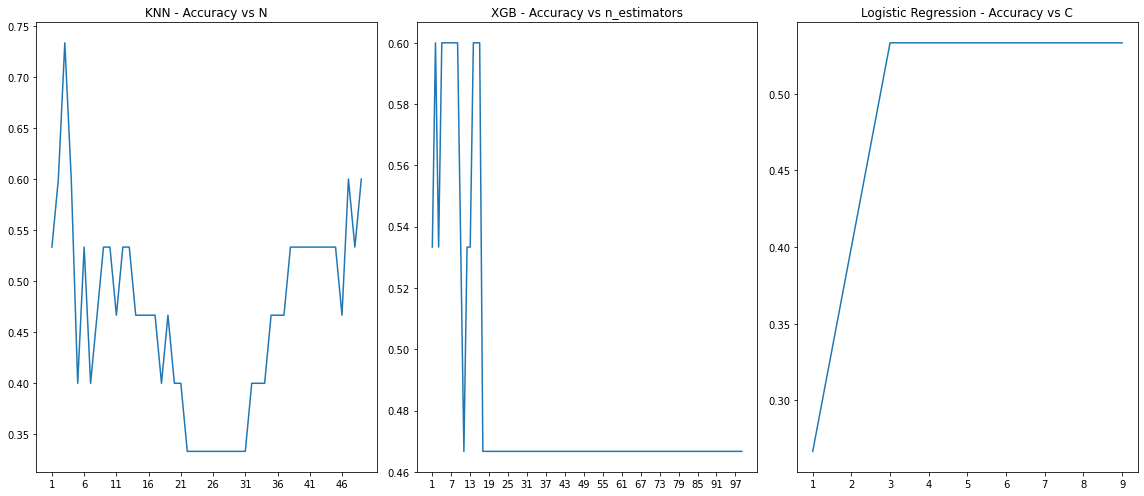

In [32]:
#Logistic Regression
plot_scores_logreg= []
cs = [0.01,0.02,0.1,0.5,1,3,4,5,10]
for c in cs:
    clf_logreg = LogisticRegression(C=c,solver='lbfgs',multi_class='ovr')
    clf_logreg.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf_logreg.predict(X_test))
    plot_scores_logreg.append(scores)
fig = plt.figure(figsize = (16,7))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(range(1,50),plot_scores_knn);
ax1.set_title("KNN - Accuracy vs N")
ax1.set_xticks(range(1,50,5));

ax2 = fig.add_subplot(1,3,2)
ax2.plot(range(1,100),plot_scores_XGB);
ax2.set_xticks(range(1,100,6));
ax2.set_title("XGB - Accuracy vs n_estimators")

ax3 = fig.add_subplot(1,3,3)
ax3.plot(range(1,10),plot_scores_logreg);
ax3.set_xticks(range(1,10));
ax3.set_title("Logistic Regression - Accuracy vs C")

fig.tight_layout()

In [33]:
max_knn_n = max(plot_scores_knn)
max_knn_ind = plot_scores_knn.index(max_knn_n)

max_XGB_e = max(plot_scores_XGB)
max_XGB_ind = plot_scores_XGB.index(max_XGB_e) if plot_scores_XGB.index(max_XGB_e)!=0 else 1

max_logreg_c = max(plot_scores_logreg)
max_logreg_ind = plot_scores_logreg.index(max_logreg_c)

if max_logreg_ind == 0:
    max_logreg_ind = 1

print(max_knn_n, max_knn_ind)
print(max_XGB_e, max_XGB_ind)
print(max_logreg_c, max_logreg_ind)

0.7333333333333333 2
0.6 1
0.5333333333333333 2


In [34]:
clf_knn = KNeighborsClassifier(n_neighbors=4).fit(X_train,y_train)
clf_XGB = XGBClassifier(n_estimators=4).fit(X_train,y_train)
clf_logreg = LogisticRegression(C=max_logreg_ind,solver='lbfgs',multi_class='ovr').fit(X_train,y_train)
y_pred_knn = clf_knn.predict(X_predict)
y_pred_XGB = clf_XGB.predict(X_predict)
y_pred_logreg = clf_logreg.predict(X_predict)

[22:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
this_week = test_table[['HomeTeam','AwayTeam']].loc[num_games:]
this_week['Result_knn']=y_pred_knn
this_week['Result_XGB']=y_pred_XGB
this_week['Result_logreg']=y_pred_logreg

In [36]:
this_week

,HomeTeam,AwayTeam,Result_knn,Result_XGB,Result_logreg
191,Chelsea,Man City,0,1,1


In [37]:
this_week["Res_knn"] = this_week.apply(lambda row: transformResultBack(row,"Result_knn"),axis=1)
this_week["Res_XGB"] = this_week.apply(lambda row: transformResultBack(row,"Result_XGB"),axis=1)
this_week["Res_logreg"] = this_week.apply(lambda row: transformResultBack(row,"Result_logreg"),axis=1)

this_week.drop(["Result_knn", "Result_XGB","Result_logreg"],axis=1,inplace=True)

In [38]:
print(max_knn_n, max_XGB_e, max_logreg_c)
this_week

0.7333333333333333 0.6 0.5333333333333333


,HomeTeam,AwayTeam,Res_knn,Res_XGB,Res_logreg
191,Chelsea,Man City,D,H,H
